In [25]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag

import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary
from Solvers import type_mask, partial, ket, instance_mask
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
def nthRootsOfUnity(n): # linear space, parallelizable
    return np.exp(2j * np.pi / n * np.arange(n))

In [26]:
def get_phase_oracles(problem):
    oracles = {}
    n = problem.n
    roots = nthRootsOfUnity(n)
    for instance in problem.instances:
        oracle = np.zeros((n,n),np.complex64)
        for i in range(n):
            oracle[i, i] = roots[problem.alphabet.index(instance[i])]
        oracles[instance] = oracle
        
    return oracles

def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        print(oracles[instance])
    return oracles

def get_oracle_diffs(oracles):
    oracle_diffs = {} 
    for v1 in oracles:
        for v2 in oracles:
            oracle_diffs[(v1, v2)] = np.eye(oracles[v1].shape[0])- oracles[v1].T @ oracles[v2]
            
    return oracle_diffs
    
def get_permutation_oracles(problem):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = problem.n
    assert tuple(range(n)) == problem.alphabet
    for instance in problem.instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles
    
    
def oracle_min_sdp(problem, oracles, eps=1/3):
    oracle_diffs = get_oracle_diffs(oracles)
    oracle_size = oracles[problem.instances[0]].shape[0]
    num_instances = len(problem.instances)
    t = cp.Variable(nonneg=True)
    instance_pairs = list(itertools.product(problem.instances, problem.instances))
    block_indices = list(itertools.product(problem.instances, (0,1), problem.instances, (0,1)))
    X = {(instance1, b1, instance2, b2): cp.Variable((oracle_size, oracle_size)) for instance1, b1, instance2, b2 in block_indices}
    Y_no = cp.Variable((num_instances, num_instances), PSD=True)
    Y_yes = cp.Variable((num_instances, num_instances), PSD=True) 
    
    constraints = []
    for index1 in range(num_instances):
        instance1 = problem.instances[index1]
        for index2 in range(num_instances):
            instance2 = problem.instances[index2]
            constraints.append(
                1-Y_no[problem.instance_to_index[instance1], problem.instance_to_index[instance2]] - Y_yes[problem.instance_to_index[instance1], problem.instance_to_index[instance2]] 
                   == cp.trace(X[(instance1, 0, instance2, 1)].T@oracle_diffs[instance1, instance2])
            )
    # print(constraints, 'constraint')
    constraints += [
        Y_no[problem.instance_to_index[instance]] <= eps for instance in problem.yes_instances
    ]
    
    constraints += [
        Y_yes[problem.instance_to_index[instance]] <= eps for instance in problem.no_instances
    ]
    
    constraints += [
        cp.trace(X[(instance, b, instance, b)]) <= t for instance, b in itertools.product(problem.instances, (0,1))
    ]
    
    block_list = [list(range(2*num_instances)) for _ in range(2*num_instances)]
    for index1 in range(num_instances):
        instance1 = problem.instances[index1]
        for index2 in range(num_instances):
            instance2 = problem.instances[index2]
            block_list[index1][index2] = X[(instance1,0, instance2, 0)]
            block_list[index1 + num_instances][index2] = X[(instance1,1, instance2, 0)]
            block_list[index1][index2+num_instances] = X[(instance1,0, instance2, 1)]
            block_list[index1+num_instances][index2+num_instances] = X[(instance1,1, instance2, 1)]
    
    constraints += [
        cp.bmat(block_list) >> 0
    ]
    opt_prob = cp.Problem(cp.Minimize(t), constraints)
    opt_prob.solve(verbose=True)
    return {key: value.value for key, value in X.items()}, Y_no.value, Y_yes.value

def oracle_max_sdp(problem, oracles, eps=1/3):
    oracle_diffs = get_oracle_diffs(oracles)
    oracle_size = oracles[problem.instances[0]].shape[0]
    num_instances = len(problem.instances)
    t = cp.Variable(nonneg=True)
    
    Lambda = cp.Variable((num_instances, num_instances))
    mu = cp.Variable(num_instances, nonneg=True)
    W_list = [list(np.zeros((oracle_size, oracle_size)) for _ in range(num_instances)) for _ in range(num_instances)]
    for yes_instance in problem.yes_instances:
        yes_index = problem.instance_to_index[yes_instance]
        for no_instance in problem.no_instances:
            no_index = problem.instance_to_index[no_instance]
            W_list[no_index][ yes_index] = -Lambda[no_index, yes_index] * oracle_diffs[(no_instance, yes_instance)]
            W_list[yes_index][ no_index] = -Lambda[yes_index, no_index] * oracle_diffs[(yes_instance, no_instance)]
    
    for index in range(num_instances):
        W_list[index][index] = mu[index] * np.eye(oracle_size)
    # for i in range(num_instances):
        # for j in range(num_instances):
            # print(i,j, W_list[i][j])
    W = cp.bmat(W_list)
    
    constraints = [W >> 0]
    constraints += [
        cp.sum(mu) == 1
    ]
    constraints += [
        cp.multiply(Lambda, np.ones((num_instances, num_instances)) - type_mask(problem)) << 0 
    ]
    
    opt_prob = cp.Problem(cp.Maximize(cp.sum(Lambda)), constraints)
    opt_prob.solve(verbose=True)
    
    for i in range(num_instances):
        for j in range(num_instances):
            try:
                W_list[i][j] = W_list[i][j].value
            except:
                pass
    return np.bmat(W_list), Lambda.value, mu.value
def transpose(n):
    perm = tuple(range(n))
    no_instances = []
    for i,j in itertools.combinations(perm, 2):
        # print(i,j)
        instance = list(perm)
        instance[i] = j
        instance[j] = i
        no_instances.append(tuple(instance))
    return Problem([perm], no_instances)
    
prob = transpose(3)
print(prob)
print(prob.alphabet)
print(len(prob.yes_instances))
oracles = get_permutation_oracles(prob)
# for instance in oracles:
    # print(instance)
    # print(oracles[instance])
# W, L, mu = oracle_max_sdp(prob, oracles)
result = oracle_min_sdp(prob, oracles)



No:[(0, 1, 2)]
Yes:[(0, 2, 1), (1, 0, 2), (2, 1, 0)]
(0, 1, 2)
3
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) May 21 12:08:40 PM: Your problem has 609 variables, 29 constraints, and 0 parameters.
(CVXPY) May 21 12:08:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 21 12:08:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 21 12:08:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 21 12:08:40 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXP

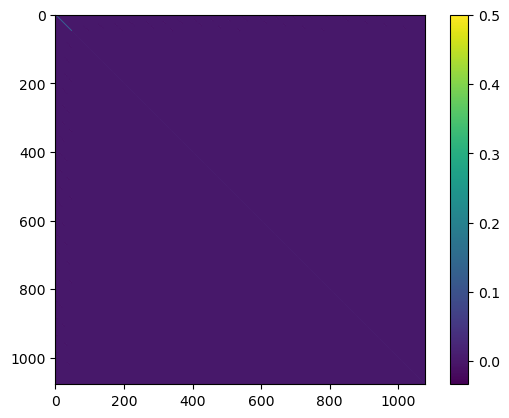

0.5241505482972401
[[42. -7. -7. ...  0.  0.  0.]
 [-7. 42. -7. ...  0.  0.  0.]
 [-7. -7. 42. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 42. -7. -7.]
 [ 0.  0.  0. ... -7. 42. -7.]
 [ 0.  0.  0. ... -7. -7. 42.]]
[ 4.90000000e+01 -6.76375818e-15  4.90000000e+01  4.90000000e+01
  4.90000000e+01  4.90000000e+01  4.90000000e+01  4.90000000e+01
 -6.76375818e-15  4.90000000e+01  4.90000000e+01  4.90000000e+01
  4.90000000e+01  4.90000000e+01  4.90000000e+01 -6.76375818e-15
  4.90000000e+01  4.90000000e+01  4.90000000e+01  4.90000000e+01
  4.90000000e+01  4.90000000e+01 -6.76375818e-15  4.90000000e+01
  4.90000000e+01  4.90000000e+01  4.90000000e+01  4.90000000e+01
  4.90000000e+01 -6.76375818e-15  4.90000000e+01  4.90000000e+01
  4.90000000e+01  4.90000000e+01  4.90000000e+01  4.90000000e+01
 -6.76375818e-15  4.90000000e+01  4.90000000e+01  4.90000000e+01
  4.90000000e+01  4.90000000e+01  4.90000000e+01 -8.54011502e-15
  4.90000000e+01  4.90000000e+01  4.90000000e+01  4.90000000e+01
  4.90000

In [118]:
plt.imshow(W)
plt.colorbar()
plt.show()
oracle_shape = oracles[prob.instances[0]].shape 
diffs = get_oracle_diffs(oracles)
no = prob.no_instances[0]
mat = np.zeros(oracle_shape)
for instance1 in prob.yes_instances:
    for instance2 in prob.yes_instances:
        pair = diffs[no, instance1] @ diffs[no, instance2].T
        mat = mat + pair
        # print(instance1, instance2)
        # print(pair)
print(np.linalg.norm(W, 2))
print(mat)
print(np.linalg.eigvals(mat))
print(np.linalg.eigvals(W))
print(np.linalg.eigvals(L))

[[-0.          0.01252363  0.01346251  0.0140779   0.01343473  0.01194367
   0.01385743  0.01422268  0.01363647  0.0131627   0.01269728  0.01294035
   0.01333922  0.01353329  0.0144837   0.01473603]
 [ 0.06201197 -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.        ]
 [ 0.06107309 -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.        ]
 [ 0.0604577  -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.        ]
 [ 0.06110087 -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.        ]
 [ 0.06259193 -0.         -0.         -0.         -0.         -0.
  -

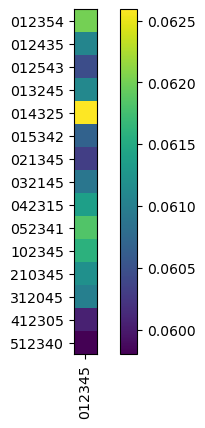

In [85]:
print(L)
adv = Adversary(prob, matrix = L)
adv.visualize_matrix()

In [86]:
prob2 = threshold_k(3, 2)
part = partial(prob2, 0)

In [87]:
np.round(np.linalg.eig(part)[1], 5)

array([[-0.5    , -0.70711,  0.5    , -0.     , -0.     , -0.     ],
       [-0.5    ,  0.70711,  0.5    ,  0.     ,  0.     , -0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.70711,  0.70711,  0.     ],
       [ 0.     ,  0.     ,  0.     , -0.70711,  0.70711, -0.     ],
       [-0.5    ,  0.     , -0.5    ,  0.     , -0.     , -0.70711],
       [-0.5    ,  0.     , -0.5    ,  0.     , -0.     ,  0.70711]])

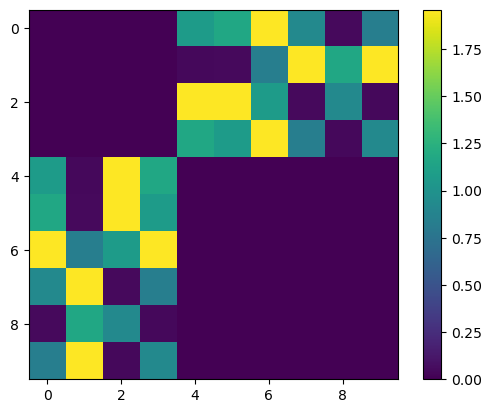

8 2


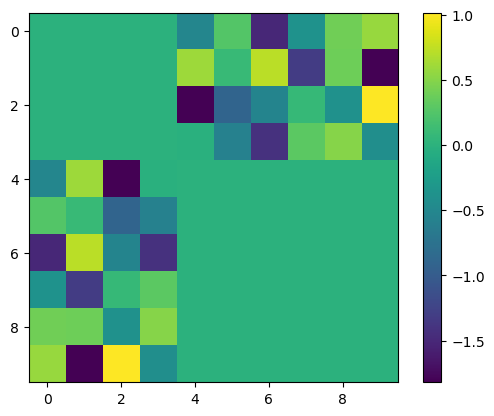

8 6


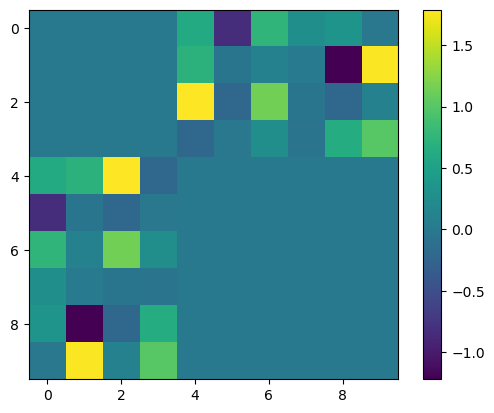

8 6


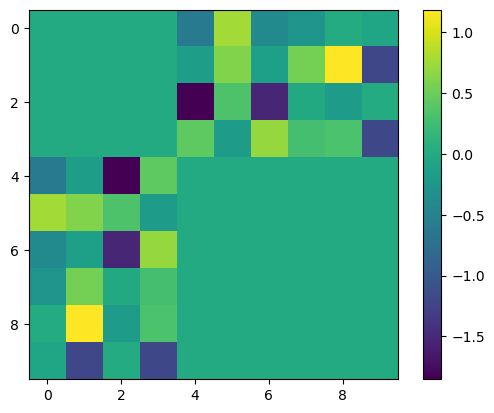

8 6


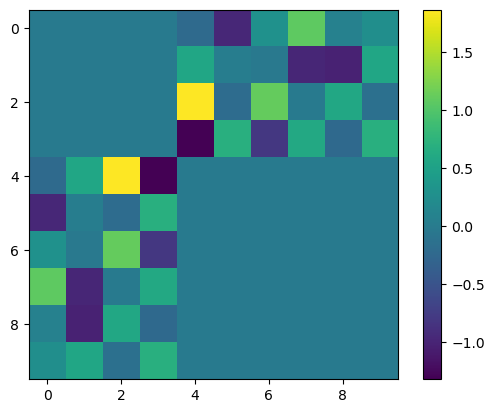

8 6


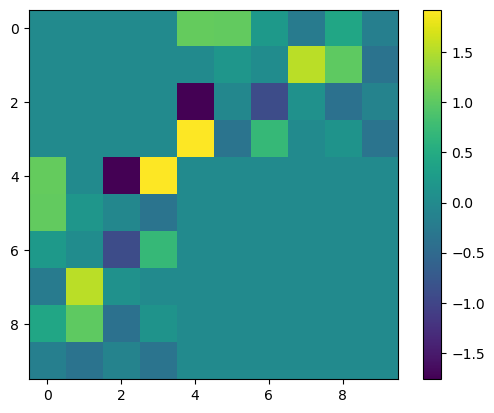

8 6


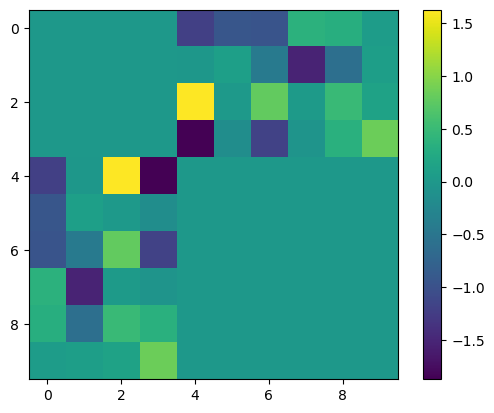

8 6


In [88]:
def gram(vectors):
    G = np.zeros((len(vectors), len(vectors)))
    for i in range(len(vectors)):
        for j in range(len(vectors)):
            G[i,j] = np.dot(vectors[i], vectors[j])
    return G

def get_algo_vectors(initial_states, unitary, problem, oracles=None, t=10):
    if oracles is None:
        oracles = get_phase_oracles(problem)
    progression = [[unitary@v for v in initial_states]]
    for _ in range(t):
        curr_states = progression[-1]
        progression.append(
            [unitary@oracles[problem.instances[i]]@curr_states[i] for i in range(problem.len)]
        )
    return progression

prob = threshold_k(4,2)
oracles = get_phase_oracles(prob)
n = 4
workspace = 0
t = 2
workspace_dim = 0 if workspace == 0 else 2**workspace
H = 1/(n + workspace_dim)*scipy.linalg.hadamard(n + workspace_dim)
initial_vectors =  np.array([ket(1, n + workspace_dim) for _ in range(prob.len)])
algo_vectors = get_algo_vectors(initial_vectors, scipy.stats.ortho_group.rvs(n + workspace_dim), prob, oracles, 7)
mask = type_mask(prob)
for i in range(len(algo_vectors)-1):
    curr_mat = gram(algo_vectors[i])
    next_mat = gram(algo_vectors[i+1])
    # G = gram(vects)
    diff = mask*(curr_mat - next_mat)
    
    plt.imshow(diff)
    plt.colorbar()
    plt.show()
    print(rank(diff), rank(mask*curr_mat))
# query_vectors = [np.array([oracles[prob.instances[i]] @ initial_vectors[i] for i in range(prob.len)])
# query_mat = type_mask(prob) * gram(query_vectors)
# print(query_mat, np.linalg.matrix_rank(query_mat))
# print(type_mask(prob), rank(type_mask(prob)))

In [80]:
X = scipy.stats.ortho_group.rvs(3)
print(X@X.T)

[[ 1.00000000e+00 -1.14754218e-16  6.72398654e-17]
 [-1.14754218e-16  1.00000000e+00  3.49260398e-17]
 [ 6.72398654e-17  3.49260398e-17  1.00000000e+00]]


In [102]:
print(*[1,2,3])

1 2 3


In [24]:
D = np.eye(5)
D[0,0] = -1
D[1,1] = -1
D[2,2] = 0
log = scipy.linalg.logm(D)
print(D)
print(np.round(log, 5))
print(scipy.linalg.expm(log))

[[-1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]
[[ -0.    +3.14159j   0.    +0.j        0.    +0.j        0.    +0.j
    0.    +0.j     ]
 [  0.    +0.j       -0.    +3.14159j   0.    +0.j        0.    +0.j
    0.    +0.j     ]
 [  0.    +0.j        0.    +0.j      -46.0517+0.j        0.    +0.j
    0.    +0.j     ]
 [  0.    +0.j        0.    +0.j        0.    +0.j        0.    +0.j
    0.    +0.j     ]
 [  0.    +0.j        0.    +0.j        0.    +0.j        0.    +0.j
    0.    +0.j     ]]
[[-1.e+00+1.2246468e-16j  0.e+00+0.0000000e+00j  0.e+00+0.0000000e+00j
   0.e+00+0.0000000e+00j  0.e+00+0.0000000e+00j]
 [ 0.e+00+0.0000000e+00j -1.e+00-3.2162453e-16j  0.e+00+0.0000000e+00j
   0.e+00+0.0000000e+00j  0.e+00+0.0000000e+00j]
 [ 0.e+00+0.0000000e+00j  0.e+00+0.0000000e+00j  1.e-20+0.0000000e+00j
   0.e+00+0.0000000e+00j  0.e+00+0.0000000e+00j]
 [ 0.e+00+0.0000000e+00j  0.e+00+0.0000000e+00j  0.e+00+0.0000000e+00j
  

C:\Users\Blake\anaconda3\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
